# Customized DeepLab Demo

In [1]:
#@title Import
import os
import sys
import tensorflow as tf
import numpy as np

from urllib.request import urlopen
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO

sys.path.append("/home/jhpark/dohai90/workspaces/models/research")

In [2]:
#@title Helper method
class DeepLabModel(object):
    """Class to load deeplab model and run inference"""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, graph_path):
        """Load pretrained deeplab model"""
        self.graph = tf.Graph()
        
        self.graph_def = None
        with tf.gfile.Open(graph_path, 'rb') as f:
            self.graph_def = tf.GraphDef.FromString(f.read())
            
        if self.graph_def is None:
            raise RuntimeError('Cannot read inference graph')
            
        with self.graph.as_default():
            tf.import_graph_def(self.graph_def, name='')
            
        self.sess = tf.Session(graph=self.graph)
        
    def run(self, image):
        """Runs inference on a single image
        
        Args:
            image: A PIL.Image object, raw input image
            
        Returns:
            resized_imaged: RGB image resized from original input image
            seg_map: Segmentation map of 'resized_image'
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,
                                     feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        print(batch_seg_map.shape)
        return resized_image, seg_map
    

def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)
    
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.
    
    Args:
        label: A 2D array with interger type,storing the segmentation label.
    
    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label 
            to the PASCAL color map.
            
    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color map maximum entry.    
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
        
    colormap = create_pascal_label_colormap()
    
    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
        
    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
    
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation image')
    
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [3]:
#@title Select model

# base model path
BASE_PATH = '/home/jhpark/dohai90/models'
# @param ['mobilenetv2_coco_voctrainaug', 'xception_coco_voctrainaug']
MODEL_NAME = 'mobilenetv2_coco_voctrainaug' 

_MODEL_PATH = {
    'mobilenetv2_coco_voctrainaug': os.path.join(BASE_PATH, 'deeplabv3_mnv2_pascal_train_aug/mnv2_frozen_inference_graph.pb'),
    'xception_coco_voctrainaug': os.path.join(BASE_PATH, 'deeplabv3_pascal_train_aug/frozen_inference_graph.pb')
}

model_path = _MODEL_PATH[MODEL_NAME]
MODEL = DeepLabModel(model_path)
print('model loaded successfully!')

model loaded successfully!


# Run on sample images

Running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...
(1, 487, 513)
(487, 513)


/home/jhpark/dohai90/venv/tf-gpu-src/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


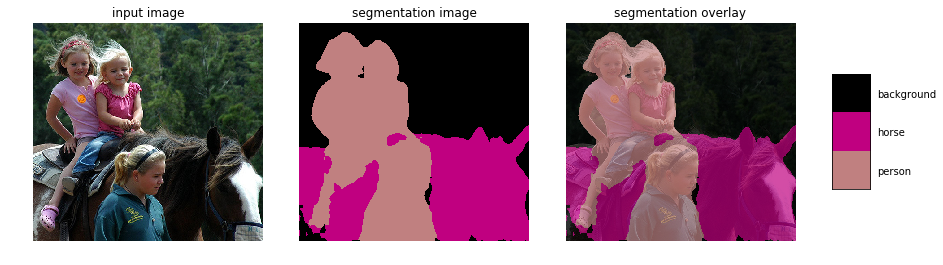

In [4]:
#@title Run on sample images
SAMPLE_IMAGE = 'image3'
SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

def run_visualization(url):
    """Inferences DeepLab model and viusalizes result."""
    try: 
        f = urlopen(url)
        jpeg_str = f.read()
        original_img = Image.open(BytesIO(jpeg_str))
    except IOError:
        print('Cannot retrieve image. Please check url: '+ url)
        return
    
    print('Running deeplab on image %s...' % url)
    resized_img, seg_map = MODEL.run(original_img)
    print(seg_map.shape)
    vis_segmentation(resized_img, seg_map)
    
img_url = SAMPLE_URL % SAMPLE_IMAGE
run_visualization(img_url)

# Note

In [5]:
f = urlopen(img_url)
jpeg_str = f.read()
ori_img = Image.open(BytesIO(jpeg_str))
type(ori_img)

PIL.JpegImagePlugin.JpegImageFile

In [6]:
ori_img.size    # ImageFIle has size (width, height)

(500, 475)

In [7]:
np_img = np.asarray(ori_img)
np_img.shape    # numpy array has shape (height, width, depth)

(475, 500, 3)

In [11]:
wts = [n for n in MODEL.graph_def.node if n.op=='Const']    # filter weights

In [12]:
from tensorflow.python.framework import tensor_util

for n in wts:
    print("name %s" %n.name)
    print("shape ", tensor_util.MakeNdarray(n.attr['value'].tensor).shape)

name strided_slice/stack
shape  (1,)
name strided_slice/stack_1
shape  (1,)
name strided_slice/stack_2
shape  (1,)
name strided_slice_1/stack
shape  (1,)
name strided_slice_1/stack_1
shape  (1,)
name strided_slice_1/stack_2
shape  (1,)
name strided_slice_2/stack
shape  (1,)
name strided_slice_2/stack_1
shape  (1,)
name strided_slice_2/stack_2
shape  (1,)
name sub/x
shape  ()
name Maximum/y
shape  ()
name sub_1/x
shape  ()
name Maximum_1/y
shape  ()
name Reshape/tensor
shape  (3,)
name Reshape/shape
shape  (3,)
name Rank
shape  ()
name Equal/y
shape  ()
name Assert/Assert/data_0
shape  ()
name Assert/Assert/data_1
shape  ()
name strided_slice_3/stack
shape  (1,)
name strided_slice_3/stack_1
shape  (1,)
name strided_slice_3/stack_2
shape  (1,)
name strided_slice_4/stack
shape  (1,)
name strided_slice_4/stack_1
shape  (1,)
name strided_slice_4/stack_2
shape  (1,)
name Assert_1/Assert/data_0
shape  ()
name Assert_2/Assert/data_0
shape  ()
name sub_3/y
shape  ()
name sub_5/y
shape  ()
name 

shape  (256,)
name image_pooling/BatchNorm/moving_mean
shape  (256,)
name image_pooling/BatchNorm/moving_variance
shape  (256,)
name ResizeBilinear/size
shape  (2,)
name aspp0/weights
shape  (1, 1, 320, 256)
name aspp0/BatchNorm/gamma
shape  (256,)
name aspp0/BatchNorm/beta
shape  (256,)
name aspp0/BatchNorm/moving_mean
shape  (256,)
name aspp0/BatchNorm/moving_variance
shape  (256,)
name concat/axis
shape  ()
name concat_projection/weights
shape  (1, 1, 512, 256)
name concat_projection/BatchNorm/gamma
shape  (256,)
name concat_projection/BatchNorm/beta
shape  (256,)
name concat_projection/BatchNorm/moving_mean
shape  (256,)
name concat_projection/BatchNorm/moving_variance
shape  (256,)
name logits/semantic/weights
shape  (1, 1, 256, 21)
name logits/semantic/biases
shape  (21,)
name ResizeBilinear_1/size
shape  (2,)
name Shape_4
shape  (4,)
name strided_slice_6/stack
shape  (1,)
name strided_slice_6/stack_1
shape  (1,)
name strided_slice_6/stack_2
shape  (1,)
name ArgMax/dimension
shap